In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pylab as plt
import seaborn as sns
plt.style.use('ggplot')
pd.set_option('display.max_columns', 200)
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mri-and-alzheimers/oasis_cross-sectional.csv
/kaggle/input/mri-and-alzheimers/oasis_longitudinal.csv


# Data Cleanup

In [2]:
cross_sectional = pd.read_csv('/kaggle/input/mri-and-alzheimers/oasis_cross-sectional.csv')
cross_sectional.head()


,ID,M/F,Hand,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF,Delay
0,OAS1_0001_MR1,F,R,74,2.0,3.0,29.0,0.0,1344,0.743,1.306,NaN
1,OAS1_0002_MR1,F,R,55,4.0,1.0,29.0,0.0,1147,0.810,1.531,NaN
2,OAS1_0003_MR1,F,R,73,4.0,3.0,27.0,0.5,1454,0.708,1.207,NaN
3,OAS1_0004_MR1,M,R,28,NaN,NaN,NaN,NaN,1588,0.803,1.105,NaN
4,OAS1_0005_MR1,M,R,18,NaN,NaN,NaN,NaN,1737,0.848,1.010,NaN


In [3]:
cross_sectional = cross_sectional.drop(columns = ['ID', 'Delay','Hand'])
cross_sectional = cross_sectional.dropna(subset = ['CDR'])
cross_sectional.head()

,M/F,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF
0,F,74,2.0,3.0,29.0,0.0,1344,0.743,1.306
1,F,55,4.0,1.0,29.0,0.0,1147,0.810,1.531
2,F,73,4.0,3.0,27.0,0.5,1454,0.708,1.207
8,M,74,5.0,2.0,30.0,0.0,1636,0.689,1.073
9,F,52,3.0,2.0,30.0,0.0,1321,0.827,1.329


In [4]:
# convert gender to binary (0 = f, 1 = m)
dummies = pd.get_dummies(cross_sectional['M/F']).astype(int)
dummies = dummies.drop('F', axis='columns')
dummies.head()
cross_sectional = pd.concat([cross_sectional, dummies], axis='columns')
cross_sectional = cross_sectional.drop('M/F', axis='columns')
cross_sectional = cross_sectional.rename(columns = {"M":"isMale"})
cross_sectional.head()

,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF,isMale
0,74,2.0,3.0,29.0,0.0,1344,0.743,1.306,0
1,55,4.0,1.0,29.0,0.0,1147,0.810,1.531,0
2,73,4.0,3.0,27.0,0.5,1454,0.708,1.207,0
8,74,5.0,2.0,30.0,0.0,1636,0.689,1.073,1
9,52,3.0,2.0,30.0,0.0,1321,0.827,1.329,0


In [5]:
# fill nulls in SES
ses_mean = cross_sectional.loc[:, 'SES'].mean()
cross_sectional['SES'] = cross_sectional['SES'].fillna(value=ses_mean)

# Linear Regression

In [6]:
column=[]
for i in cross_sectional.columns.array:
  if i!='CDR':
    column.append(i)

col = pd.Series(column).to_numpy()
x = [[] for _ in range(len(cross_sectional[col[0]]))]
for i in range(len(cross_sectional[col[0]])):
  for j in range(len(col)):
    x[i].append(cross_sectional[col[j]].to_numpy()[i])

In [7]:
def simpleLR(X, Y, X2, Y2):
  model = LinearRegression().fit(X, Y, sample_weight=None)
  b1 = model.coef_
  b0 = model.intercept_
  yhat = model.predict(X2)
  score = r2_score(Y2, yhat)
  return b0, b1, yhat, score

[0.0519778673078225, 0.004947517171594695, 0.035803433184202316, 0.5781789864921287, -0.027974520780375878, 0.2036120666301907, -0.025705626421467453, -0.011600316922643072]


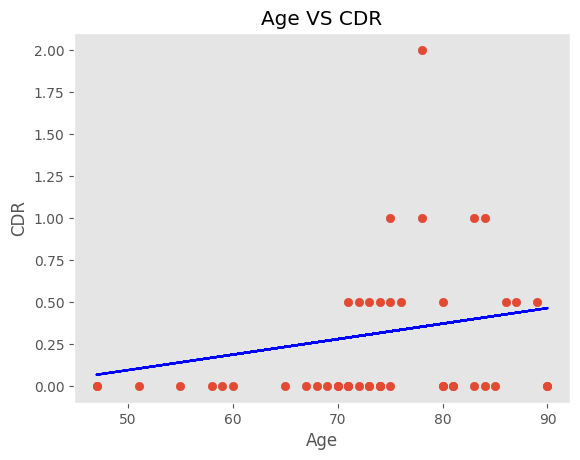

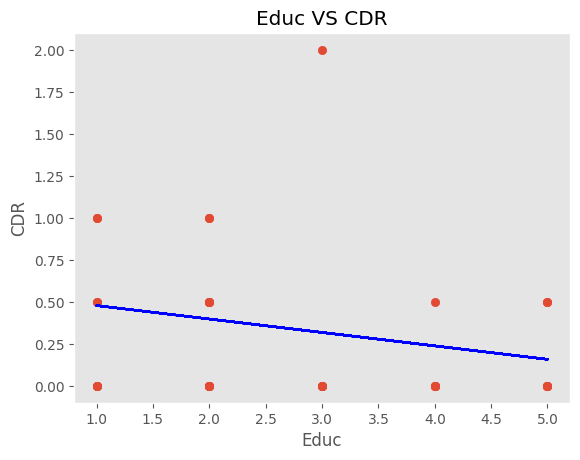

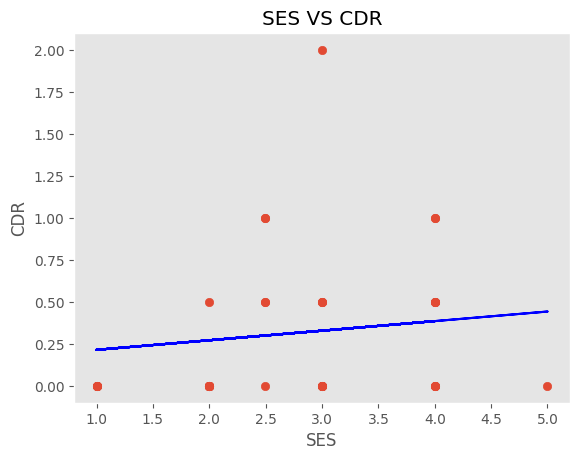

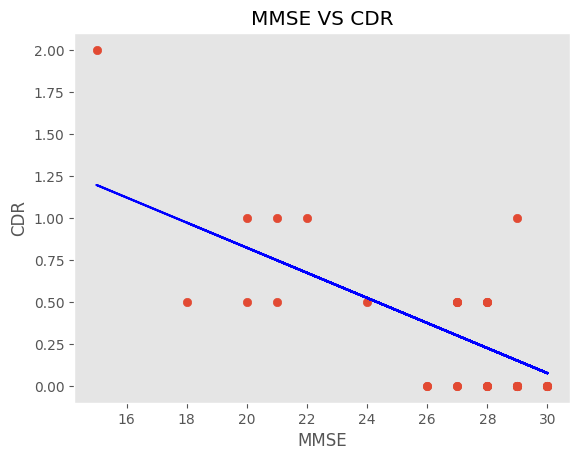

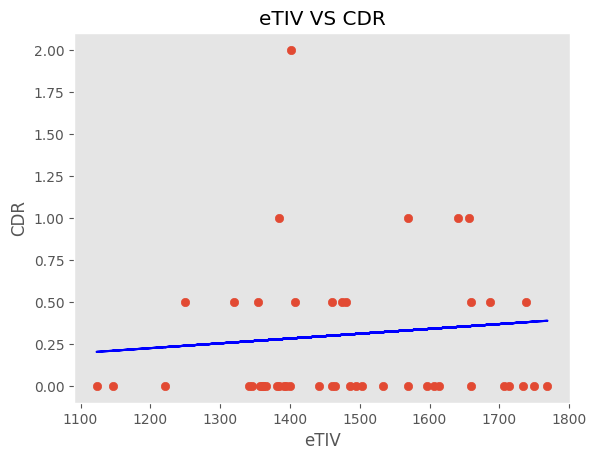

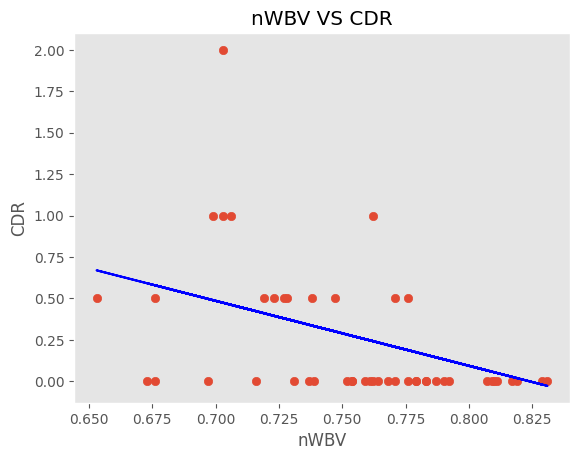

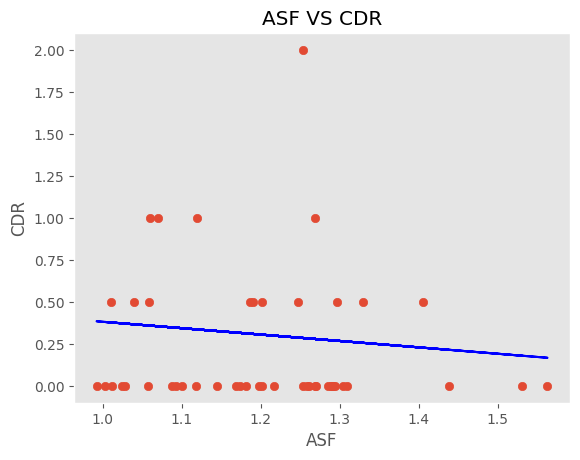

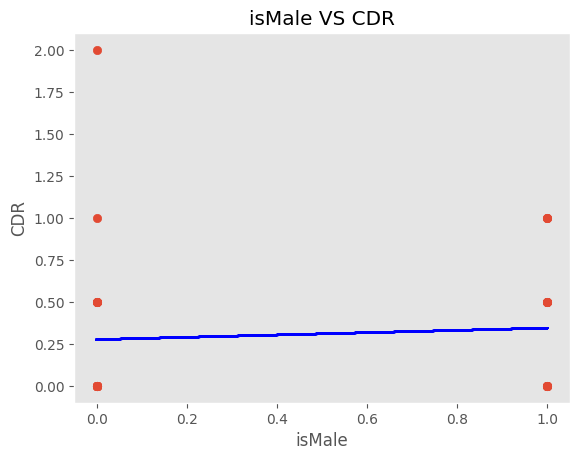

In [8]:
import matplotlib.pyplot as plt

results = {'Independent Variable': [], 'b0': [], 'b1': [], 'R2 Score': []}
train = cross_sectional.sample(frac = 0.8, random_state = 31)
test = cross_sectional.drop(train.index)

for i in col:
  plt.subplots()
  b0, b1, yhat, score = simpleLR(train[[i]], train[['CDR']],test[[i]], test[['CDR']])
  results['Independent Variable'].append(i)
  results['b0'].append(b0[0])
  results['b1'].append(b1[0][0])
  results['R2 Score'].append(score)
  plt.scatter(test[i], test['CDR'])
  plt.plot(test[i], yhat, 'b')
  plt.xlabel(i) 
  plt.ylabel("CDR")
  plt.title(i + " VS CDR")
  plt.grid()
print(results['R2 Score'])

In [9]:
def MLR(X,Y,X2, Y2):
  regr = LinearRegression()
  regr.fit(X,Y)
  b0 = regr.intercept_
  b1 = regr.coef_
  yhat = regr.predict(X2)
  score = r2_score(Y2, yhat)
  return b0, b1, score



In [10]:
key = ['Number of Independent Variables', 'Best R2 Score']
key.extend(col)
zeros = [0 for i in range(7)]
value = [zeros.copy() for i in range(len(key))]
results = {k:v for (k, v) in zip(key, value)}
def gen_subset(indep, n):
  if n == 0:
      return [[]]
  subsets =[]
  for i in range(0, len(indep)):
      m = indep[i] #first heading
      remLst = indep[i + 1:] #the rest of indep
      remainlst_combo = gen_subset(remLst, n-1)
      for p in remainlst_combo:
        subsets.append([m, *p]) 
  return subsets

train = cross_sectional.sample(frac = 0.8, random_state = 31)
test = cross_sectional.drop(train.index)

for i in range(2, 9):
  best_b0, best_b1, best_score, best_indep = 0, 0, 0, []
  for j in gen_subset(col, i):
    x = np.asanyarray(train[j])
    y = np.asanyarray(train['CDR'])
    x2 = np.asanyarray(test[j])
    y2 = np.asanyarray(test['CDR'])
    b0, b1, score = MLR(x,y,x2,y2)
    if score > best_score:
      best_score, best_b0, best_b1, best_indep = score, b0, b1, j
  for name in best_indep:
    results[name][i-2] = 1
  results['Number of Independent Variables'][i-2] = i
  results['Best R2 Score'][i-2] = best_score

results = pd.DataFrame(results)
display(results)

,Number of Independent Variables,Best R2 Score,Age,Educ,SES,MMSE,eTIV,nWBV,ASF,isMale
0,2,0.589967,0,0,0,1,0,0,0,1
1,3,0.590789,0,0,1,1,0,0,0,1
2,4,0.585082,0,0,1,1,0,1,0,1
3,5,0.584856,1,0,1,1,0,1,0,1
4,6,0.579536,0,0,1,1,1,1,1,1
5,7,0.577884,1,0,1,1,1,1,1,1
6,8,0.562302,1,1,1,1,1,1,1,1


# Random Forest Model

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
X = cross_sectional.drop(['CDR'], axis=1)
y = cross_sectional['CDR']

In [12]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 28)

In [13]:
fc = RandomForestClassifier()
fc.fit(x_train, y_train.astype("string"))

RandomForestClassifier()

In [14]:
yfc_pred = fc.predict(x_test)
dfc = pd.DataFrame({"prediction" : yfc_pred, "actual" : y_test.astype("string").tolist()})
print(classification_report(y_test.astype("string"), yfc_pred))

              precision    recall  f1-score   support

         0.0       0.96      0.92      0.94        25
         0.5       0.45      0.82      0.58        11
         1.0       0.67      0.20      0.31        10
         2.0       0.00      0.00      0.00         1

    accuracy                           0.72        47
   macro avg       0.52      0.48      0.46        47
weighted avg       0.76      0.72      0.70        47



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [15]:
# Initializing the Random Forest Regression model with 10 decision trees
forest = RandomForestRegressor(n_estimators = 10, random_state = 0)

# Fitting the Random Forest Regression model to the data
forest.fit(x_train, y_train)

RandomForestRegressor(n_estimators=10, random_state=0)

In [16]:
# Predicting the target values of the test set
y_pred = forest.predict(x_test)
df = pd.DataFrame({"prediction" : y_pred, "actual" : y_test.tolist()})
df

,prediction,actual
0,0.45,0.0
1,0.30,0.5
2,0.50,0.5
3,0.30,1.0
4,0.75,1.0
5,0.50,0.5
6,0.00,0.0
7,0.00,0.0
8,0.05,0.0
9,0.65,0.5


In [17]:
# RMSE (Root Mean Square Error)
rmse = float(format(np.sqrt(mean_squared_error(y_test, y_pred)), '.4f'))
print("\nRMSE: ", rmse)


RMSE:  0.2886


In [18]:
# Normalized RMSE
max_val = cross_sectional['CDR'].max()
min_val = cross_sectional['CDR'].min()
n_rmse = rmse / (max_val - min_val)
print("Normalized RMSE: ", n_rmse)

Normalized RMSE:  0.1443


# Data Visualization

<Axes: >

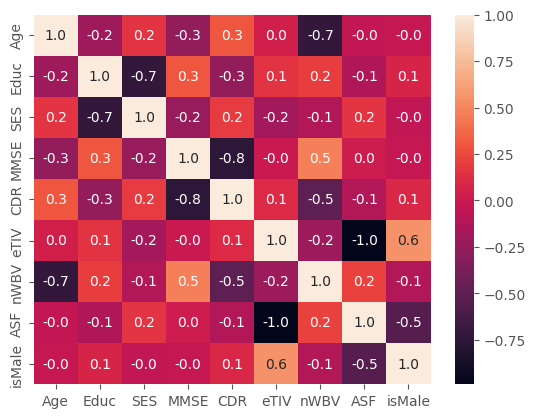

In [19]:
# heatmap showing correlations 
cross_sectional_corr = cross_sectional[cross_sectional.columns.values.tolist()].dropna().corr()

sns.heatmap(data=cross_sectional_corr, annot=True, fmt=".1f")

/tmp/ipykernel_18/1419962546.py:5: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(cross_sectional['Age'], palette=sns.color_palette('pastel')[1:3], bins=50, ax=ax[0]);
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/ipykernel_18/1419962546.py:8: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(cross_sectional['MMSE'], palette=sns.color_palette('pastel')[1:3], bins=50, ax=ax[3]);
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/ipykernel_18/1419962546.py:9: UserWarning:

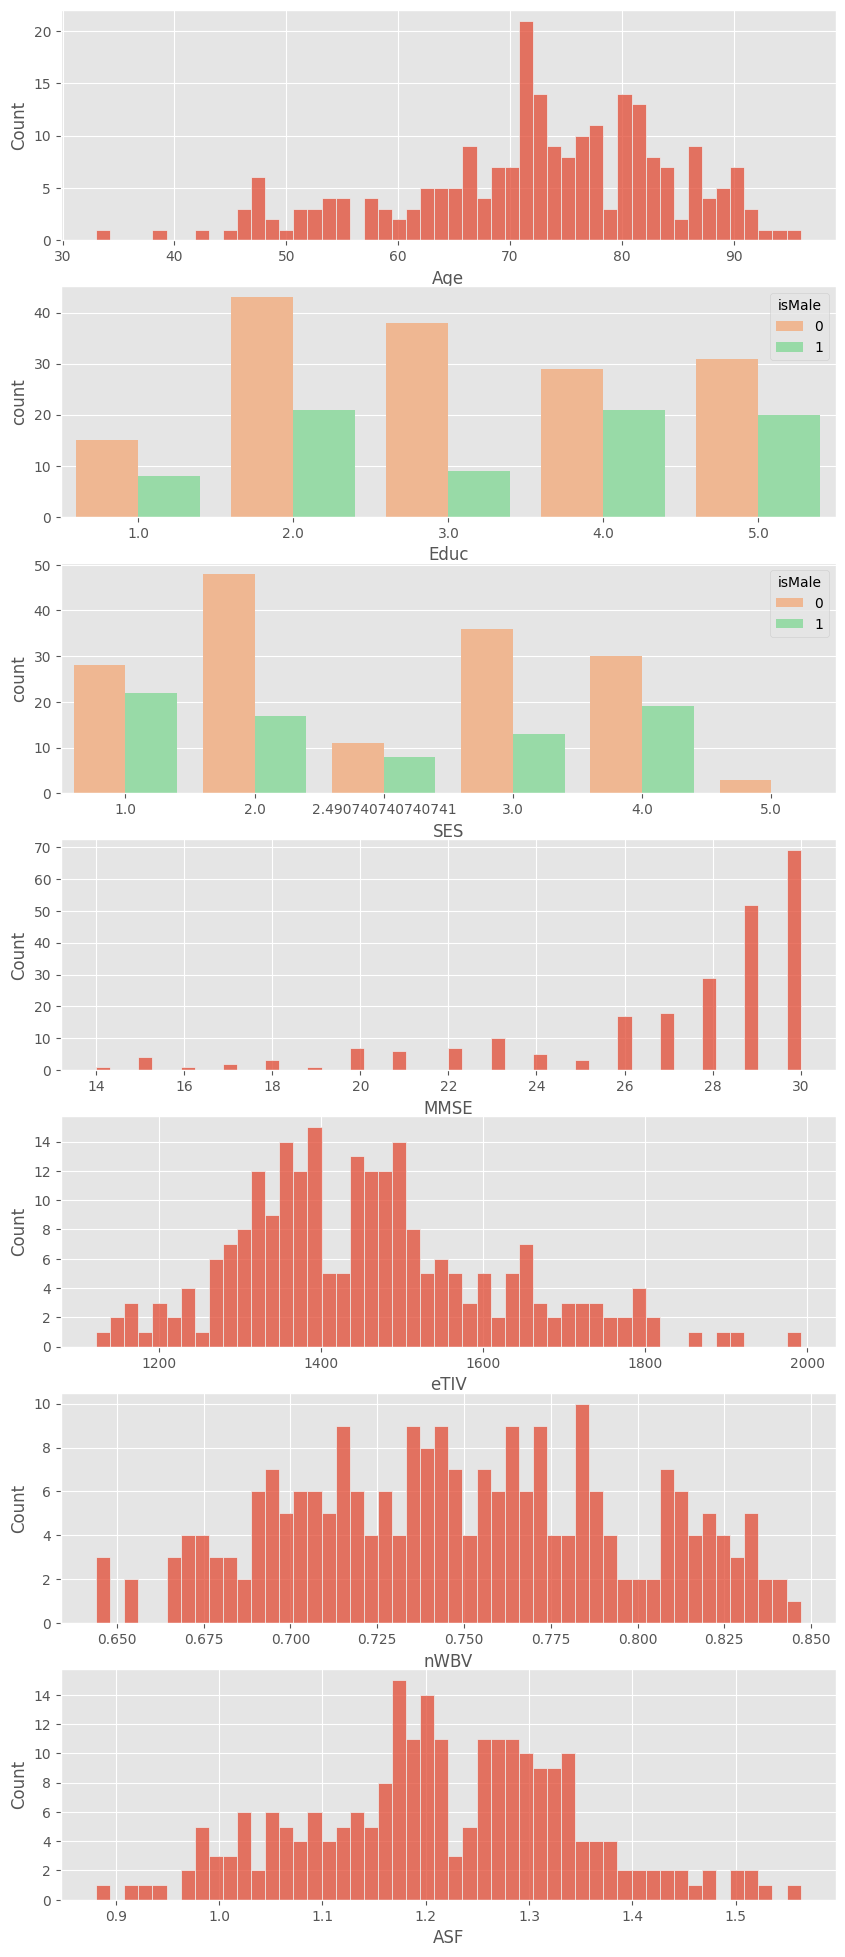

In [20]:
# General distributions of numerical data. Note that the vast majority of passengers spend very little money.
fig, ax = plt.subplots(7,1, figsize=(10, 10))
plt.subplots_adjust(top = 2)

sns.histplot(cross_sectional['Age'], palette=sns.color_palette('pastel')[1:3], bins=50, ax=ax[0]);
sns.countplot(cross_sectional, x='Educ', hue='isMale', palette=sns.color_palette('pastel')[1:3],ax=ax[1]);
sns.countplot(cross_sectional, x='SES', hue='isMale', palette=sns.color_palette('pastel')[1:3],ax=ax[2]);
sns.histplot(cross_sectional['MMSE'], palette=sns.color_palette('pastel')[1:3], bins=50, ax=ax[3]);
sns.histplot(cross_sectional['eTIV'], palette=sns.color_palette('pastel')[1:3], bins=50, ax=ax[4]);
sns.histplot(cross_sectional['nWBV'], palette=sns.color_palette('pastel')[1:3], bins=50, ax=ax[5]);
sns.histplot(cross_sectional['ASF'], palette=sns.color_palette('pastel')[1:3], bins=50, ax=ax[6]);

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated a

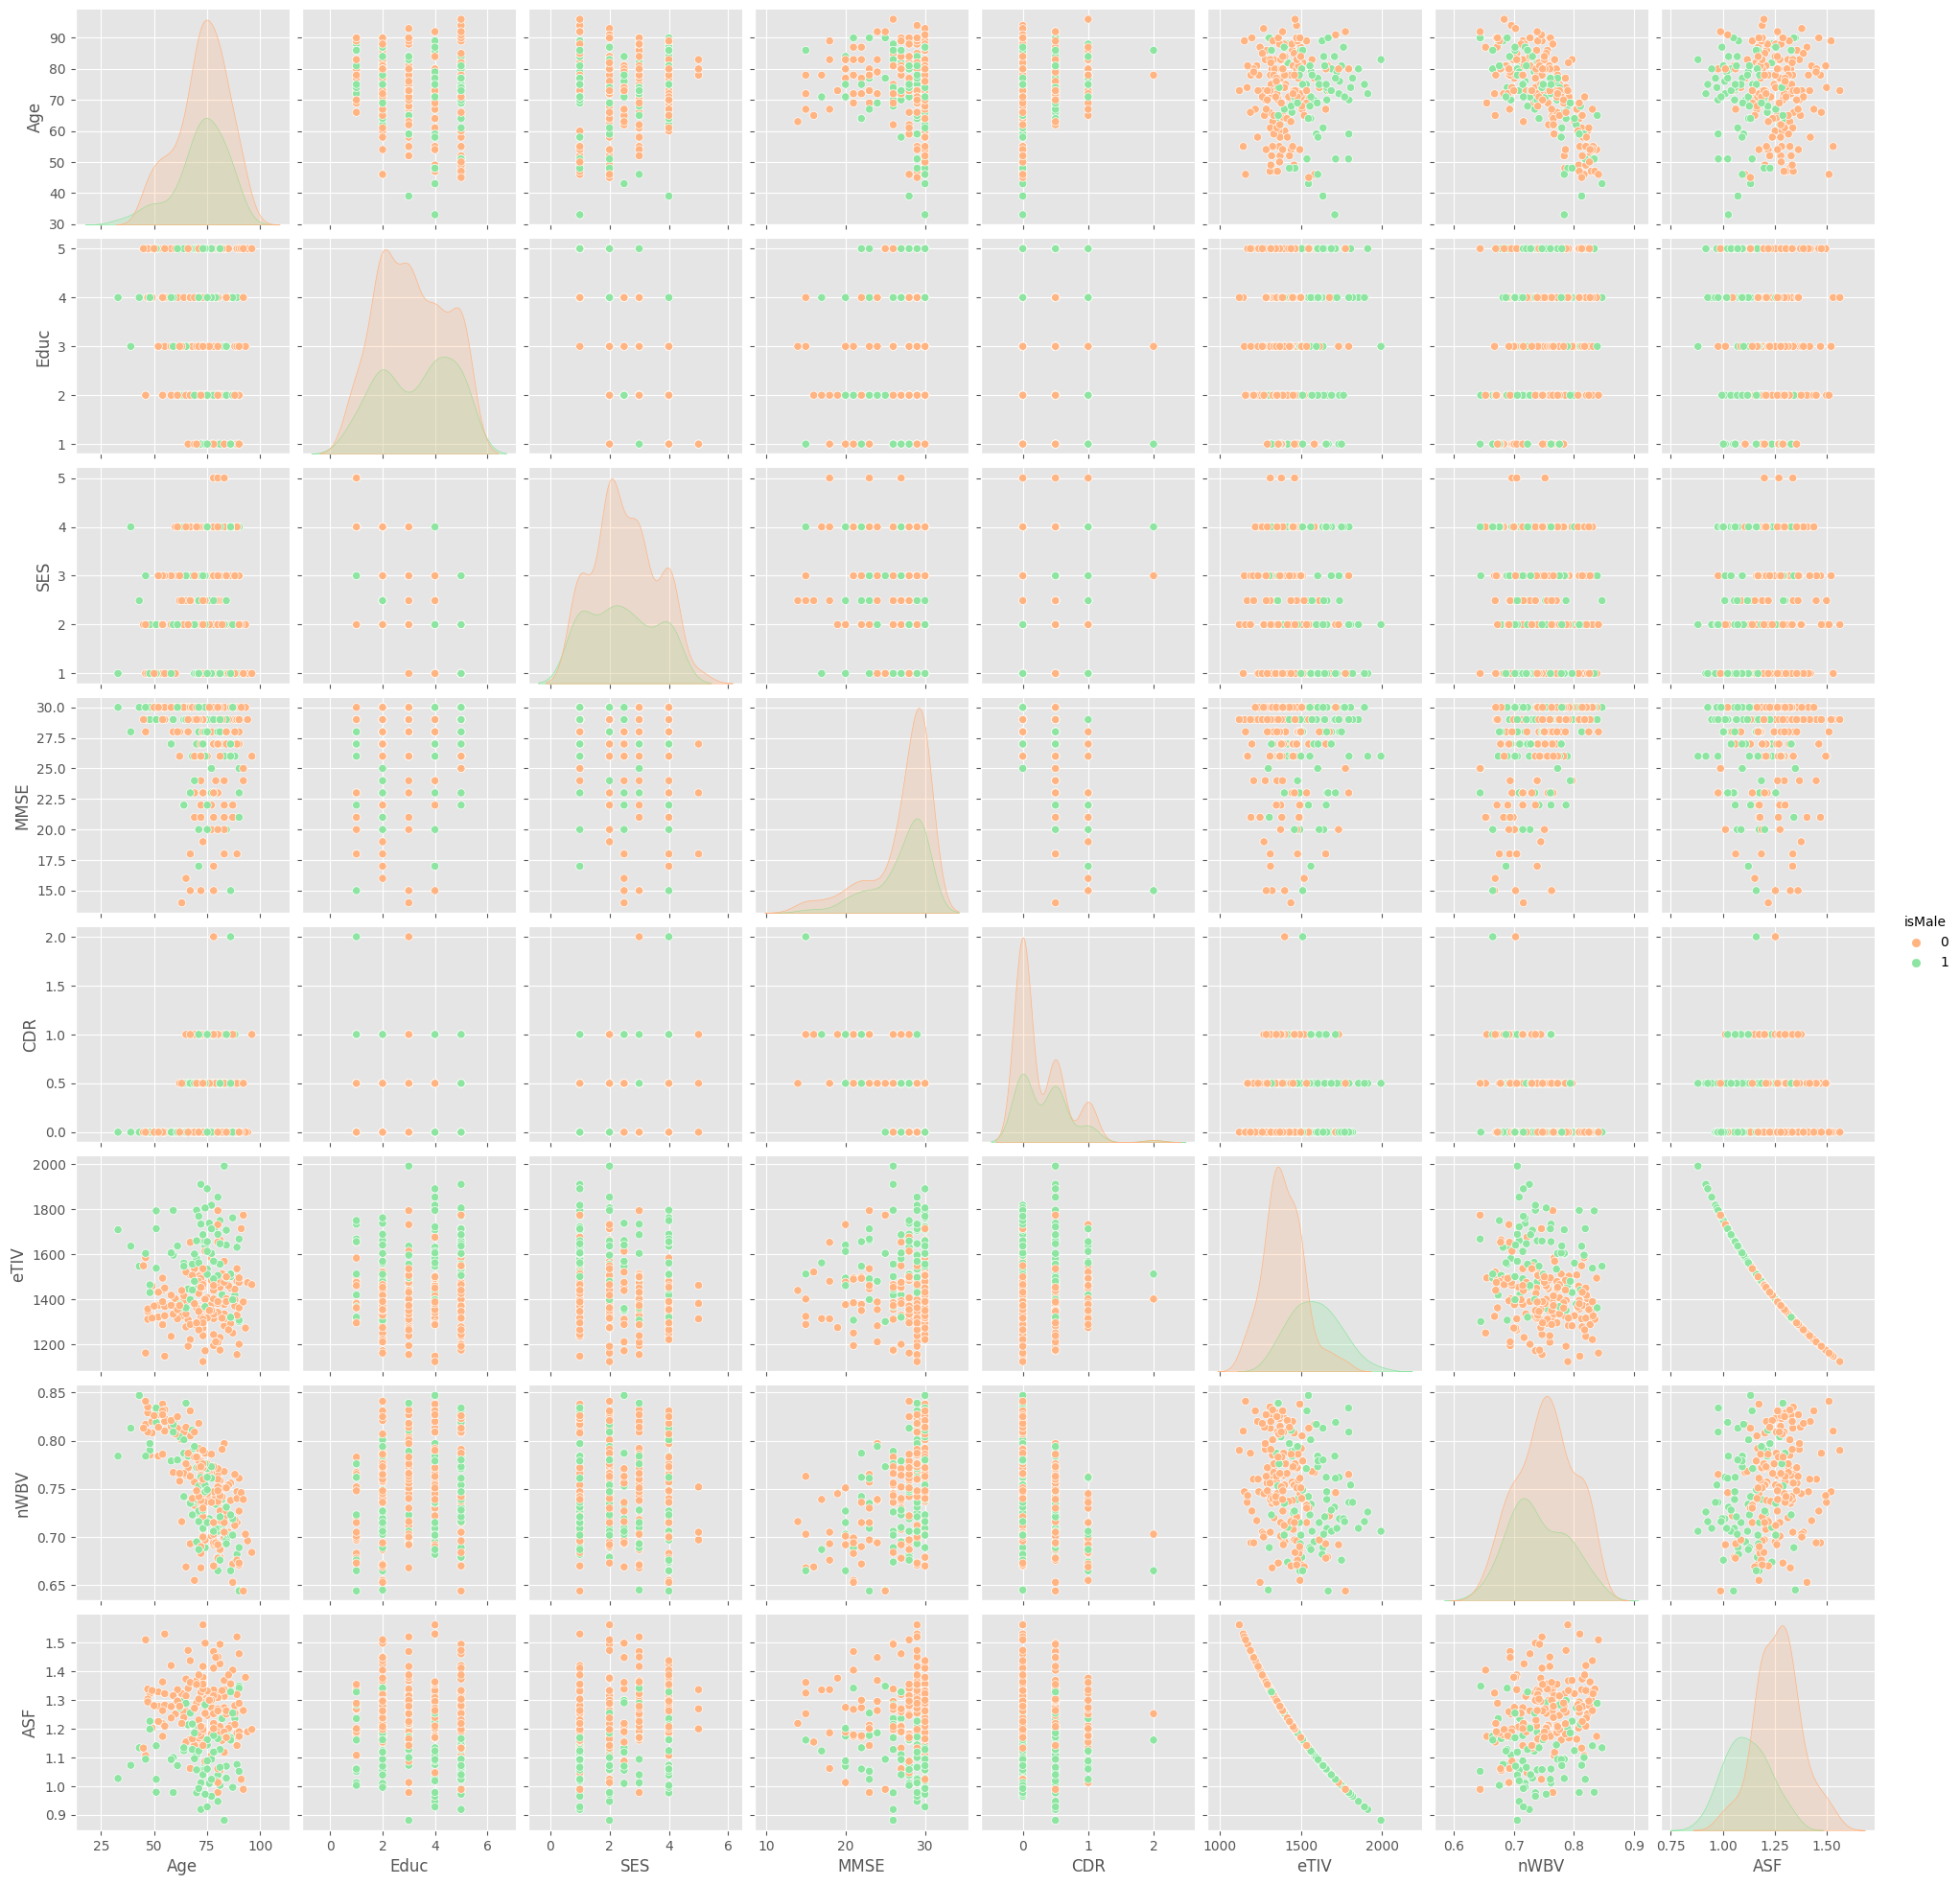

In [21]:
sns.pairplot(cross_sectional, 
             vars=['Age', 'Educ', 'SES', 'MMSE', 'CDR', 'eTIV', 'nWBV', 'ASF'],
            hue='isMale', palette=sns.color_palette('pastel')[1:3])
plt.show()

Text(0.5, 1.0, 'Gender Distribution')

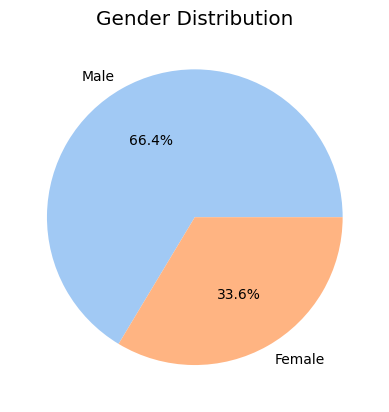

In [22]:
# Gender data in a pie
plt.pie(cross_sectional["isMale"].value_counts(),
        labels=['Male', 'Female'],
        autopct="%1.1f%%",
        colors=sns.color_palette('pastel')[0:2])
plt.title("Gender Distribution")

Text(0.5, 1.0, 'Education Distribution')

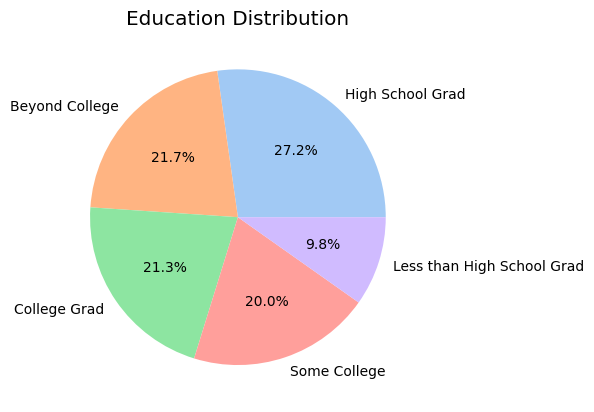

In [23]:
# Education data in a pie
plt.pie(cross_sectional["Educ"].value_counts(),
        labels=['High School Grad', 'Beyond College', 'College Grad', 'Some College', 'Less than High School Grad'],
        autopct="%1.1f%%",
        colors=sns.color_palette('pastel')[0:5])
plt.title("Education Distribution")

Text(0.5, 1.0, 'Socioeconomic Status Distribution')

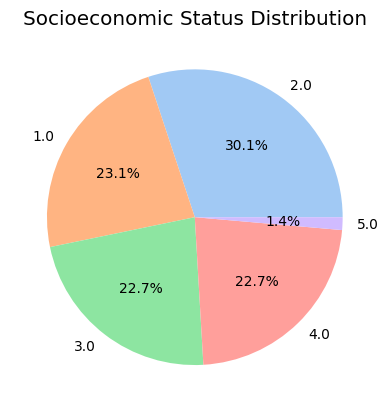

In [24]:
# SES data in a pie
mask = cross_sectional["SES"] == ses_mean
plt.pie(cross_sectional["SES"][~mask].value_counts(),
        labels=cross_sectional["SES"][~mask].value_counts().keys(),
        autopct="%1.1f%%",
        colors=sns.color_palette('pastel')[0:6])
plt.title("Socioeconomic Status Distribution")

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


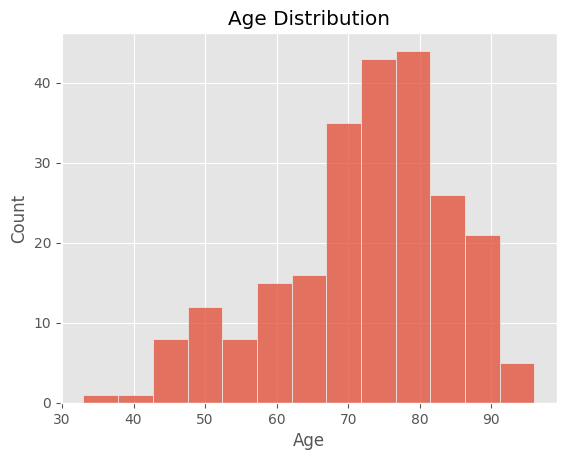

In [25]:
#Age bar graph
sns.histplot(x=cross_sectional["Age"],
             #hue="Transported",
             #data=cross_sectional,
             #palette=sns.color_palette('pastel')[1:3])
            )
plt.title("Age Distribution");

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


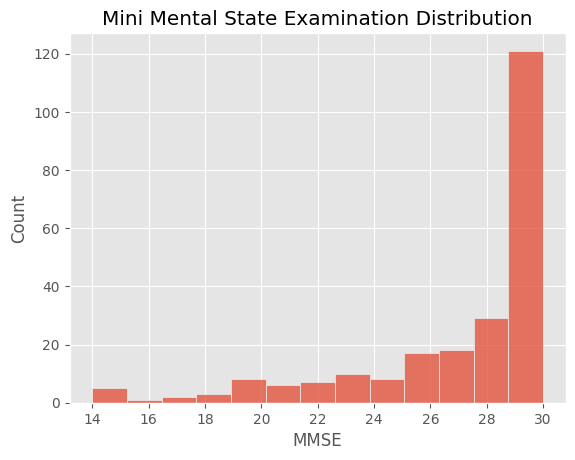

In [26]:
#MMSE bar graph
sns.histplot(x=cross_sectional["MMSE"],
             #hue="Transported",
             #data=cross_sectional,
             #palette=sns.color_palette('pastel')[1:3])
            )
plt.title("Mini Mental State Examination Distribution");

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


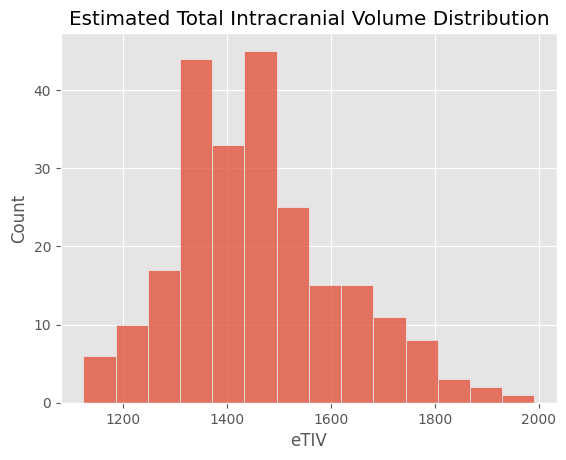

In [27]:
#eTIV
sns.histplot(x=cross_sectional["eTIV"],
             #hue="Transported",
             #data=cross_sectional,
             #palette=sns.color_palette('pastel')[1:3])
            )
plt.title("Estimated Total Intracranial Volume Distribution");

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


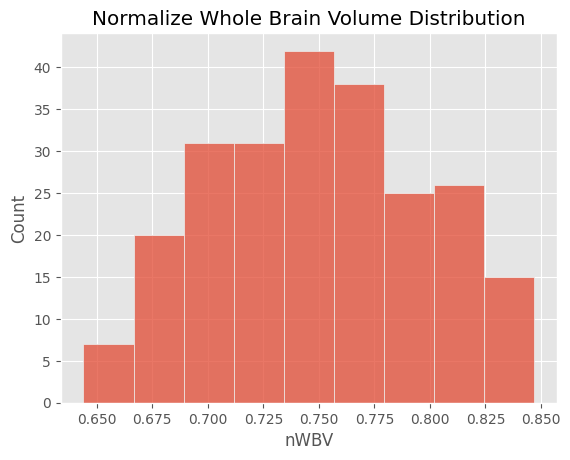

In [28]:
#nWBV
sns.histplot(x=cross_sectional["nWBV"],
             #hue="Transported",
             #data=cross_sectional,
             #palette=sns.color_palette('pastel')[1:3])
            )
plt.title("Normalize Whole Brain Volume Distribution");

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


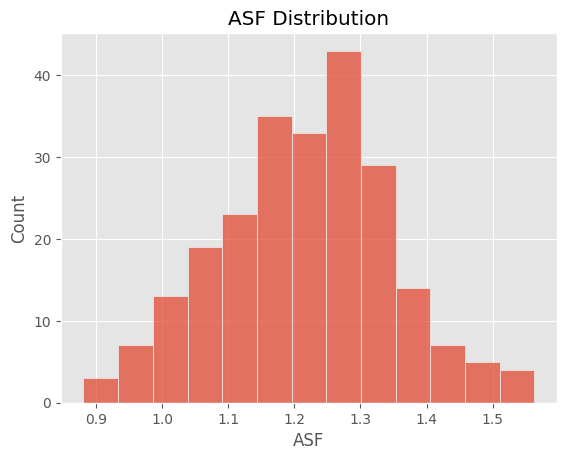

In [29]:
#ASF
sns.histplot(x=cross_sectional["ASF"],
             #hue="Transported",
             #data=cross_sectional,
             #palette=sns.color_palette('pastel')[1:3])
            )
plt.title("ASF Distribution");